La parte 2 se mueve a almacenamiento local, siendo que necesitará más recursos. Copiamos los únicos 2 archivos de BD que usaremos, de discusiones (14266) y mensajes (28436), aunque puede que haya más recortes de ahora en más.

Nuestra primera tarea es investigar el uso potencial de scikit-learn para entrenar un clasificador que asigne el ejercicio apropiado a una *conversación* (o chat) particular, siendo esta última la concatenación de todos los mensajes dentro de una consulta (incluyendo el primero, la consulta en sí). Para tokenizar intentaremos usar Spacy, como veníamos haciendo. Primero repasaremos la instalación de Spacy, y después veremos la de scikit-learn. 

Entorno virtual:
```
python -m venv .env
source .env/bin/activate
```

O bien, para activar en Windows:
```
.env\Scripts\activate.bat
```

Spacy (como recomienda en su página):
```
pip install -U pip setuptools wheel
pip install -U spacy
```

Pipeline entrenada para procesar español (eficiente):
```
python -m spacy download es_core_news_sm
```

Pipeline entrenada para procesar español (precisa):
```
python -m spacy download es_dep_news_trf
```

Si solo necesitamos tokenizar, podemos usar el cógigo de lenguage **'es'** sin recurrir a ninguna pipeline.

Ahora, Scikit-learn (también según la página oficial).

```
pip install -U scikit-learn
```

Construiremos los *chats* como hicimos en la parte 1. Como Scikit debe usar Spacy y al mismo tiempo intepretar cada conversación por separado, debemos dejar cada conversación en su forma natural: una concatenación de mensajes (esto también se recomienda en la documentación de Scikit). Una opción es hacer un arreglo de tamaño 14266; no obstante, como vamos a tener una *clase* (ejercicio) asociada a cada conversación, podemos organizarlas de acuerdo a esas clases. Luego podemos hacer filtros adicionales, ya sea de clases (si queremos que cada clase tenga como mínimo un cierto número de conversaciones) o de la conversación en sí (por ejemplo dejando las que tienen cierta longitud como máximo; a esta altura del proceso sólo se puede limitar por caracteres).

In [ ]:
from filterTools import csvFilter
from datetime import datetime
from functools import reduce

dt_format = '%Y-%m-%d %H:%M:%S.%f'

discs = csvFilter('db/discussions.csv', lambda _: True)
msgs = csvFilter('db/messages.csv', lambda _: True)
all_chats = {}
for disc in discs:
    responses = []
    for i, msg in enumerate(msgs):
        if disc['id'] == msg['discussion_id']:
            responses.append(msg)
            msgs.pop(i)
    responses.sort(key=lambda msg: datetime.strptime(msg['created_at'], dt_format))
    text = reduce(lambda text, res: text + ' ' + res['content'], responses, disc['description'])
    all_chats[disc['item_id']] = all_chats.get(disc['item_id'], []) + [text]

# funcion para contar todas las conversaciones
def total_chats(chats):
    return reduce(lambda count, ex: count + len(ex), list(chats.values()), 0)

print(f'Conversaciones totales: {total_chats(all_chats)}')

Para simplificar, aplicaremos todos los filtros en el mismo lugar. Primero van los que se aplican a *todas* las conversaciones colectivamente, e independiente de la clase. Por ejemplo, limitar las conversaciones por longitud tiene que hacerse *antes* de filtrar las clases por cantidad de conversaciones (siendo que algunas serán eliminadas). Luego del segundo filtro, el que se aplica a las clases, *separamos* el conjunto que nos queda en subconjuntos para entrenamiento, testeo, etc. Por el momento nos basamos en un solo número, necesariamente >50, que es el porcentaje de conversaciones que quedan para el entrenamiento. La restricción >50 no sólo es lógica, sino que nos asegura que al redondear, nos queda al menos 1 conversación en cada ejercicio para entrenamiento (aunque esto no está recomendado! Usar un min_ex > 1 para el filtro 2).

In [ ]:
from random import shuffle

max_length = 5000
min_ex = 10
train_percent = 80  # %

def filter_chat(chat):
    return len(chat) <= max_length

def filter_ex(chats):
    return len(chats) >= min_ex

filtered_chats = {}
for ex, chats in all_chats.items():
    filtered = list(filter(filter_chat, chats))
    if filtered:
        filtered_chats[ex] = filtered
print(f'Conversaciones tras filtros individuales: {total_chats(filtered_chats)}')
print(f'Ejercicios totales: {len(filtered_chats)}')

filtered_chats = {ex: chats for ex, chats in filtered_chats.items() if filter_ex(chats)}
print(f'\nConversaciones tras filtros de clase: {total_chats(filtered_chats)}')
print(f'Ejercicios totales: {len(filtered_chats)}')

print(f'\nLISTA DE EJERCICIOS')
for ex, chats in filtered_chats.items():
    print(f'Ejercicio {ex}: {len(chats)} discusiones')

train_chats, test_chats = {}, {}
for ex, chats in filtered_chats.items():
    slice_i = round(train_percent*len(chats)/100)
    shuffle(chats)
    train_chats[ex] = chats[:slice_i]
    test_chats[ex] = chats[slice_i:]
filtered_chats.clear()

print(f'\nConversaciones para entrenamiento: {total_chats(train_chats)}')
print(f'\nLISTA DE EJERCICIOS ({len(train_chats)})')
for ex, chats in train_chats.items():
    print(f'Ejercicio {ex}: {len(chats)} discusiones')

print(f'\nConversaciones para test: {total_chats(test_chats)}')
print(f'\nLISTA DE EJERCICIOS ({len(test_chats)})')
for ex, chats in test_chats.items():
    print(f'Ejercicio {ex}: {len(chats)} discusiones')

Teníamos 122 ejercicios, pero si limitamos los que tienen al menos 10 discusiones, nos quedamos con sólo 73! Notar que el número que elijamos será el número de *clases* que el clasificador interpretará; jamás intentará asignar un ejercicio que no esté en esta lista. Aunque no apliquemos ningún filtro, hay ejercicios completamente vacíos, y por ende no se pueden considerar (como máximo podemos usar 109).

A partir de aquí podemos empezar a ver cómo usar Scikit-learn junto con Spacy. En primer lugar, Scikit tiene una manera estándar de interpretar los datos. La primera etapa de cualquier *pipeline* de entrenamiento es transformar los datos nuestros en algo que entienda Scikit, normalmente con la forma **n_samples**X**n_features**, donde *n_samples* es el número de datos, y *n_features* el número de características que pueden asociarse a cualquiera de estos datos. Cada característica tiene un valor, normalmente numérico, y cada dato es una combinación de estos valores. Scikit trabaja con una matriz que de exactamente esta forma; lo que hay que ver en cada caso en particular es cuáles son los *features* qué valores darles.

En el caso de análisis de texto, Scikit recomienda el método de "bolsa de palabras", en el cual se cuenta el número de repeticiones de cada palabra. Las *features* serán las palabras en sí, y *n_features* la longitud del vocabulario global. Y para transformar nuestros strings en objetos ya contados y en el formato adecuado, tenemos una función en particular, la cual además tokeniza; nos basta aclararle que para tokenizar, use una función distinta. La matriz que se construye usa el formato *scipy.sparse* que guarda sólo los valores distintos de 0, de esa manera ahorrando mucho espacio en memoria. Al final, cada fila representa una conversación separada exactamente en las palabras que se usan en esa conversación, y nada más.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import spacy as sp

nlp = sp.load('es_core_news_sm')

def tokenizer(text):
    tokens = nlp(text)
    return [token.text for token in tokens]
    
count_vect = CountVectorizer(tokenizer=tokenizer)
tfidf_transformer = TfidfTransformer()

def add_class(chats, key):
    chats[0] = chats[0] + train_chats[key]
    chats[1] = chats[1] + [key]*len(train_chats[key])
    return chats
    
all_train_chats = reduce(add_class, list(train_chats.keys()), [[], []])
print(f'Chats: {len(all_train_chats[0])}')
print(f'Clases: {len(all_train_chats[1])}')
chat_counts = tfidf_transformer.fit_transform(count_vect.fit_transform(all_train_chats[0]))
print(f'Matriz: {chat_counts.shape}')

Nos queda elegir el modelo, y en particular el algoritmo que se usará para predecir nuevos resultados luego del "ajuste" (*fit*), que es lo que entendemos por *entrenamiento*. Un primer acercamiento que proponemos es usar *regresión logística*, que en este caso, al tratarse de más de 2 clases, tiene que ser multinomial. Scikit soporta regresión logística con un sinfín de parámetros, entre ellos el algoritmo a utilizar: soporta *lbfgs*, *liblinear*, *newton-cg*, *newton-cholesky*, *sag* y *saga*, este último siendo el que más configuraciones acepta.

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial').fit(chat_counts, all_train_chats[1])

clf.score(chat_counts, all_train_chats[1])

Para automatizar el proceso entero, construiremos explícitamente una *pipeline* con parámetros propios. Por suerte, la parte que corresponde a Scikit ya tiene funciones para ese fin.

Replantearemos todo el proceso (copiando código si es necesario), organizándolo en 3 partes, cada una sólo dependiente de la anterior:
* Levantar los datos, filtrarlos, separarlos en conjuntos de entrenamiento y test, y exportarlos a un archivo (para almacenamiento persistente; no nos conviene que la separación *random* de conversaciones dependa de la sesión).
* Construir el modelo, por el momento con los parámetros que creamos más convenientes. Estos luego se pueden buscar con Grid Search (pero ojo la eficiencia!) Incluimos aquí también el procesamiento previo que genera la matriz de vectores. Exportamos el modelo entrenado a un archivo.
* Testear el modelo; hará falta usar el mismo procesamiento sobre el conjunto de test (pero esto Scikit lo hace internamente). Elegiremos varias métricas que puedan ser relevantes para el caso de un clasificador multiclase.


In [1]:
from filterTools import csvFilter
from dataTools import build_chats, total_chats, filter_chats, filter_classes, split_chats
import json

# Recopilación de datos

## Formato de fecha que usamos
dt_format = '%Y-%m-%d %H:%M:%S.%f'

## Leemos las tablas que tenemos
discs = csvFilter('db/discussions.csv')
msgs = csvFilter('db/messages.csv')

## Creamos las conversaciones y las organizamos en un diccionario
## En este ya estan clasificadas por ejercicio
all_chats = build_chats(discs, msgs, dt_format)
print(f'Conversaciones totales: {total_chats(all_chats)}')

# Etapa de filtros
max_length = 5000
min_ex = 10
train_percent = 80 # %
dev_percent = 0 # %

## Funcion que filtra las conversaciones (pueden agregarse mas cosas aqui)
def chat_filter(chat):
    return len(chat) <= max_length

## Funcion que filtra las clases (pueden agregarse mas cosas aqui)
def ex_filter(chats):
    return len(chats) >= min_ex

## Filtramos en orden (importante)
filtered_chats = filter_chats(all_chats, chat_filter)
print(f'\nConversaciones tras filtros individuales: {total_chats(filtered_chats)}')
print(f'Ejercicios totales: {len(filtered_chats)}')

filtered_chats = filter_classes(filtered_chats, ex_filter)
print(f'\nConversaciones tras filtros de clase: {total_chats(filtered_chats)}')
print(f'Ejercicios totales: {len(filtered_chats)}')

## Creamos un diccionario para cada subconjunto y separamos equilibradamente (de acuerdo al % elegido)
(train_chats, test_chats, dev_chats) = split_chats(filtered_chats, train_percent, dev_percent)
filtered_chats.clear()

print(f'\nConversaciones para entrenamiento: {total_chats(train_chats)}')
print(f'Conversaciones para test: {total_chats(test_chats)}')
if dev_percent > 0:
    print(f'Conversaciones para validación: {total_chats(dev_chats)}')

## Convertimos a json y los escribimos en archivos separados
with open('data/train_chats.json', 'w', encoding='utf-8') as f1:
    json.dump(train_chats, f1)
print('\nConjunto de entrenamiento guardado!')
train_chats.clear()

with open('data/test_chats.json', 'w', encoding='utf-8') as f2:
    json.dump(test_chats, f2)
print('Conjunto de test guardado!')
test_chats.clear()

if dev_percent > 0:
    with open('data/dev_chats.json', 'w', encoding='utf-8') as f3:
        json.dump(dev_chats, f3)
    print('Conjunto de validación guardado!')
    dev_chats.clear()

Conversaciones totales: 14266

Conversaciones tras filtros individuales: 14159
Ejercicios totales: 109

Conversaciones tras filtros de clase: 14006
Ejercicios totales: 73

Conversaciones para entrenamiento: 11208
Conversaciones para test: 2798

Conjunto de entrenamiento guardado!
Conjunto de test guardado!


In [2]:
import json
from dataTools import separate_classes, tokenizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
import joblib as jl

# Recuperación de los datos guardados
with open('data/train_chats.json', 'r', encoding='utf-8') as f1:
    train_chats = json.load(f1)
print('Conjunto de entrenamiento cargado\n')

## Separamos los chats de sus clases (etiquetas)
all_train_chats = separate_classes(train_chats)


# Etapa de entrenamiento

## Funcion wrapper que inserta los (hiper)parámetros que elegimos en la pipeline de Scikit
## Los que no tienen valor por defecto son los que hay que optimizar
## max_iter y tol son iguales que en Scikit, pero podriamos querer cambiarlos
def build_pipeline(lowercase, norm, use_idf, l1_ratio, C, tokenizer=tokenizer, solver='saga', multi_class='multinomial', penalty='elasticnet', max_iter=100, tol=0.0001):
    return Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenizer, lowercase=lowercase)),
        ('tfidf', TfidfTransformer(norm=norm, use_idf=use_idf)),
        ('clf', LogisticRegression(solver=solver, multi_class=multi_class, penalty=penalty, max_iter=max_iter, tol=tol, l1_ratio=l1_ratio, C=C)),
    ], verbose=True)

## Construimos explicitamente la pipeline con los parametros que parecen mas convenientes
text_clf = build_pipeline(lowercase=True, norm='l2', use_idf=True, l1_ratio=1.0, C=10, max_iter=100)

## Entrenamos
text_clf.fit(all_train_chats[0], all_train_chats[1])

## Exportamos
jl.dump(text_clf, 'models/bow/model.joblib')
print('\nModelo entrenado y guardado')

Conjunto de entrenamiento cargado



c:\Users\fran_\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[Pipeline] .............. (step 1 of 3) Processing vect, total= 9.0min
[Pipeline] ............. (step 2 of 3) Processing tfidf, total=   0.2s


c:\Users\fran_\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[Pipeline] ............... (step 3 of 3) Processing clf, total= 3.9min

Modelo entrenado y guardado


Conjunto de test cargado

Modelo cargado

METRICAS
              precision    recall  f1-score   support

       13291       0.00      0.00      0.00         2
       13292       1.00      1.00      1.00         2
       13297       1.00      1.00      1.00         3
       13299       0.00      0.00      0.00         3
       13305       0.00      0.00      0.00         3
       13306       0.50      0.33      0.40         6
       13307       0.00      0.00      0.00         2
       13308       0.00      0.00      0.00         3
       13309       0.50      0.20      0.29         5
       13319       0.33      0.50      0.40         2
       13320       0.00      0.00      0.00         5
       13323       0.00      0.00      0.00         3
       13908       1.00      0.50      0.67         2
        2736       0.80      0.87      0.84        38
        2738       0.81      0.83      0.82        42
        2740       0.81      0.85      0.83       118
        2750       0.96      0

c:\Users\fran_\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


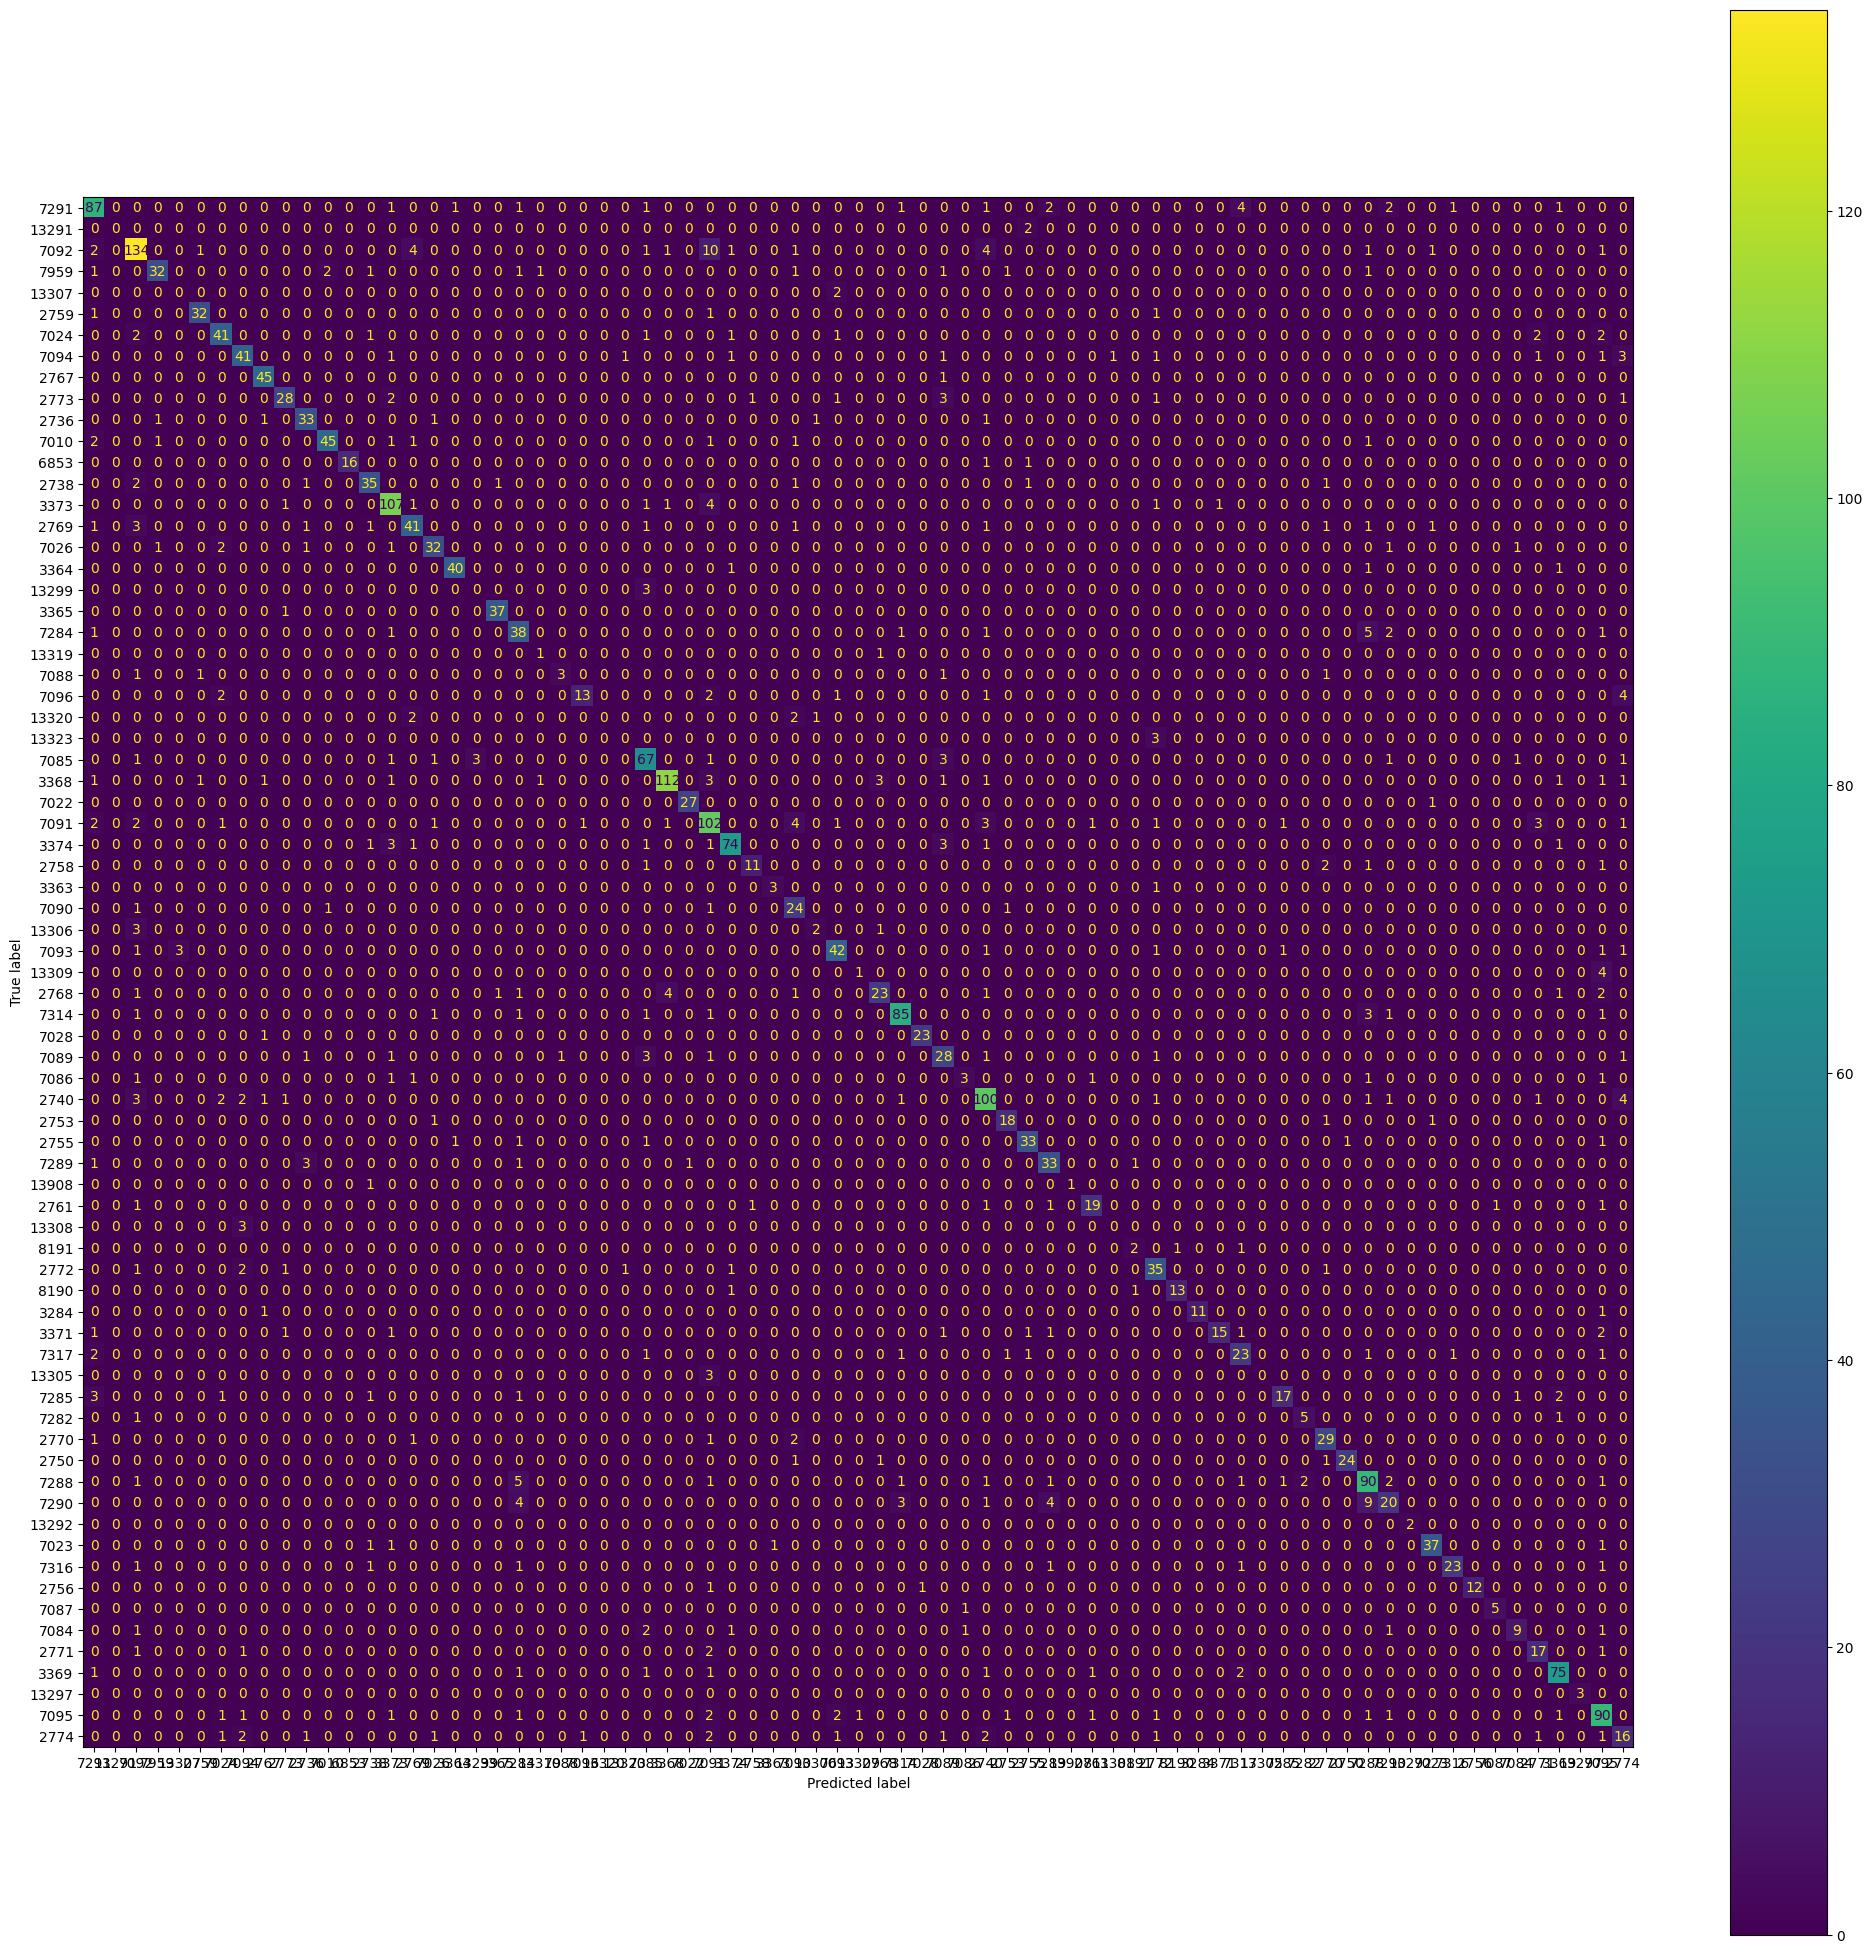

In [3]:
import json
from dataTools import separate_classes, tokenizer # esto se esta usando, aunque no parezca!
import joblib as jl
from sklearn import metrics

# Recuperación de los datos guardados
with open('data/test_chats.json', 'r', encoding='utf-8') as f2:
    test_chats = json.load(f2)
print('Conjunto de test cargado')

## Separamos los chats de sus clases (etiquetas)
all_test_chats = separate_classes(test_chats)

## Levantamos el modelo
text_clf = jl.load('models/bow/model.joblib')
print('\nModelo cargado')


# Etapa de tests
## Predicciones sobre el conjunto de test
predicted = text_clf.predict(all_test_chats[0])

labels = list(set(all_test_chats[1]))
print('\nMETRICAS')
print(metrics.classification_report(all_test_chats[1], predicted, zero_division=0))
print(f'\nAcurracy: {metrics.accuracy_score(all_test_chats[1], predicted)}')
print(f'Balanced acurracy: {metrics.balanced_accuracy_score(all_test_chats[1], predicted)}')
print(f'Precision: {metrics.precision_score(all_test_chats[1], predicted, labels=labels, average="weighted")}')
print(f'Recall: {metrics.recall_score(all_test_chats[1], predicted, labels=labels, average="weighted")}')
print(f'F1: {metrics.f1_score(all_test_chats[1], predicted, labels=labels, average="weighted")}')
print('Confusion Matrix')
cmatrix = metrics.ConfusionMatrixDisplay.from_predictions(all_test_chats[1], predicted, labels=labels)
fig = cmatrix.figure_
fig.set_figwidth(25)
fig.set_figheight(25)